In [1]:
import pandas as pd
import geopandas as gpd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Create initial datasets

### Setup input/output

In [2]:
# set base directory
#baseDIR = '/mnt/d'
baseDIR = 'T:/2-Projects/Thunder Basin/'

# set input directory
#inDIR = 'TBNG/data/veg/NEX'
inDIR = 'NestedExclosures/Data/Multi-Year Data/'

# set input file
#inXLSX = '2015-2021 Herb_16nov2021ep.xlsx'
#inXLSX = '2015-2021 Herb_24jan2022ep.xlsx'
inXLSX = '2015-2021 Herb_8Mar2022ce_fixedVOR.xlsx'

# set location file
inSHP = 'data/shps/20m_Transects_ALL_26jun2015.shp'
# NOTE: original file location T:\3-GIS\ThunderBasin\Exclosure_Study_Connell

# change working directory to be project directory
os.chdir(os.path.dirname(os.getcwd()))

# set output directories
outDIR_clip = 'data/clip'
outDIR_vor = 'data/vor'
outDIR_vor_train = 'data/vor_train'
outDIR_pf_train = 'data/pf_train'
if not os.path.exists(os.path.join(os.getcwd(), outDIR_clip)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_clip))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor_train))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_pf_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_pf_train))

### Load data

In [3]:
# create an Excel file object for investigating contents
nex_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))
#nex_xlsx = pd.ExcelFile(os.path.join('T:/2-Projects/Thunder Basin/NestedExclosures/Data/Multi-Year Data', inXLSX))

# display the sheet names in the .xlsx file
display(nex_xlsx.sheet_names)

['Metadata 15-21',
 'VOR 15-21',
 'Basal 15-21',
 'Biomass-FQ 15-21',
 'Cover 15-21',
 'Pin Frame 16-21',
 'Pin_Calibration17-21',
 'Dung 15-21',
 'Grouse Pellets 15-21',
 'Ants 15-21',
 'PDog_activity 17-21',
 'Pin_CalibClip_Shrubs 17-18',
 'Fires',
 'SmMammExcl']

In [4]:
# Create the desired dataframes by parsing the individual sheets
df_nex_bm = nex_xlsx.parse(sheet_name='Biomass-FQ 15-21', header=1, usecols='C:AL')
df_nex_pf = nex_xlsx.parse(sheet_name='Pin_Calibration17-21', header=0)
df_nex_vor = nex_xlsx.parse(sheet_name='VOR 15-21', header=0)

In [5]:
# load shapefile and drop null values
gdf_nex = gpd.read_file(inSHP)
gdf_nex = gdf_nex[gdf_nex['Name'].notnull()]
# create ID's
gdf_nex['Transect ID'] = gdf_nex.apply(lambda x: '-'.join(x[['Name', 'Disturbanc', 'Exclosure']]).lower(), axis=1)
# get centroid of each transect
gdf_nex['Mean.GPS_E.Biomass'] = gdf_nex.geometry.centroid.x
gdf_nex['Mean.GPS_N.Biomass'] = gdf_nex.geometry.centroid.y

# Biomass dataset

#### Clean up dates

In [6]:
# create a mask to identify all values that are 'date-like'
dates_bm_mask = df_nex_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# summarize to find all unique values in the 'Date' column for each year
dates_yrly_bm = pd.DataFrame(df_nex_bm.groupby('Year')['Date'].unique()).explode('Date')
# create a mask of 'date-like' values from the unique values pulled for each year
dates_yrly_bm_mask = dates_yrly_bm['Date'].map(lambda x: bool(re.match('\d\d\d\d-\d\d-\d\d 00:00:00', str(x))))
# create a Series of the 'date-like' unique values
dates_yrly_bm_good = dates_yrly_bm['Date'][dates_yrly_bm_mask].astype(np.datetime64)
# get the average date for each month of each year for manually correcting vague dates
dates_yrly_bm_avgs = dates_yrly_bm_good.groupby(['Year', dates_yrly_bm_good.dt.month_name()]).mean().dt.date

In [7]:
# display the average dates for each month of each year
display(dates_yrly_bm_avgs)

Year  Date  
2016  August    2016-08-02
      July      2016-07-08
2017  July      2017-07-19
2018  August    2018-08-03
      July      2018-07-16
      June      2018-06-16
2019  August    2019-08-06
      July      2019-07-16
      June      2019-06-25
2020  August    2020-08-06
      July      2020-07-07
2021  August    2021-08-04
      July      2021-07-13
      June      2021-06-30
Name: Date, dtype: object

In [8]:
# display the unique non-'date-like' values present in each year
display(dates_yrly_bm['Date'][~dates_yrly_bm_mask])

Year
2015                     na
2015           7/20-23/2015
2015          7/27-8/5/2015
2016           6/6-6/9/2016
2016          na, July 2016
2017          na, June 2017
2017          na, July 2017
2017        na, August 2017
2020    7/6/2020 - 7/7/2020
2020    7/8/2020 - 7/9/2020
2020      8/4/2020-8/5/2020
Name: Date, dtype: object

In [9]:
# create a dictionary to manually change non-'date-like' values to dates
dates_bm_dict = {
    2015: {
        'na': pd.to_datetime('2015-07-27').date(),
        '7/20-23/2015': pd.to_datetime('2015-07-21').date(),
        '7/27-8/5/2015': pd.to_datetime('2015-08-01').date()
    },
    2016: {
        'na, July 2016': dates_yrly_bm_avgs.loc[(2016, 'July')],
        '6/6-6/9/2016': pd.to_datetime('2016-06-08').date(),
    },
    2017: {
        'na, June 2017': pd.to_datetime('2017-06-22').date(),
        'na, July 2017': dates_yrly_bm_avgs.loc[(2017, 'July')],
        'na, August 2017': pd.to_datetime('2017-08-04').date(),
    },
    2020: {
        '7/6/2020 - 7/7/2020': pd.to_datetime('2020-07-07').date(),
        '7/8/2020 - 7/9/2020': pd.to_datetime('2020-07-09').date(),
        '8/4/2020-8/5/2020': pd.to_datetime('2020-08-05').date()
    }
}

In [10]:
# Create a new column of cleaned up dates from 'date-like' values and manual replacement
df_nex_bm.loc[dates_bm_mask, 
              'Date_cln'] = df_nex_bm['Date'][dates_bm_mask].astype(np.datetime64).dt.date
df_nex_bm.loc[~dates_bm_mask, 
              'Date_cln'] = df_nex_bm[~dates_bm_mask].apply(lambda x: dates_bm_dict[x.Year][x.Date], axis=1)
df_nex_bm['Date_cln'] = df_nex_bm['Date_cln'].astype(np.datetime64)

In [11]:
# display data types
display(df_nex_bm.dtypes)

Year                                 int64
Date                                object
Transect ID                         object
Site                                object
Disturbance                         object
Exclosure                           object
Rep                                  int64
Biomass?                            object
Forage?                             object
Pin Frame?                          object
Area (m^2)                         float64
% ARTR                              object
% sd ARTR                          float64
% KRLA                              object
% ARCA                             float64
% ATCA                             float64
# OPPO cladodes                    float64
# COVI                             float64
% OPPO                             float64
Total Weight (g)                   float64
Total Weight (g/m^2)               float64
How weighed?                        object
C4 weight (g)                       object
C3 weight (

In [12]:
# remove all rows with weight value entered as 'x'
df_nex_bm = df_nex_bm[~(
    df_nex_bm.loc[:, df_nex_bm.columns.str.contains('eight \(g\)')] == 'x').any(axis=1)]

# convert weight values to float
df_nex_bm.loc[:, df_nex_bm.columns.str.contains('eight \(g\)')] = df_nex_bm.loc[:, df_nex_bm.columns.str.contains('eight \(g\)')].astype('float')

# remove all rows with NA values for Total weight, including those signified with negative values
df_nex_bm = df_nex_bm[df_nex_bm['Total Weight (g)'].notnull()]
df_nex_bm = df_nex_bm[df_nex_bm['Total Weight (g)'] >= 0]

# remove all clipping done for PASM only
df_nex_bm = df_nex_bm[df_nex_bm['PASM or COMP?'] != 'PASM']

# manually remove several rows with missing data not yet classified with -1
#df_nex_bm = df_nex_bm[~((df_nex_bm['Date_cln'] == pd.to_datetime('2020-08-05')) &
#                        (df_nex_bm['Transect ID'] == 'west fork-control-ungulate ex'))]

#df_nex_bm = df_nex_bm[~((df_nex_bm['Date_cln'] == pd.to_datetime('2020-08-06')) &
#                        (df_nex_bm['Transect ID'] == 'wildcat-control-livestock ex'))]

#df_nex_bm = df_nex_bm[~((df_nex_bm['Date_cln'] == pd.to_datetime('2020-08-06')) &
#                        (df_nex_bm['Transect ID'] == 'wildcat-control-out'))]

### Visualize data to check that it makes sense

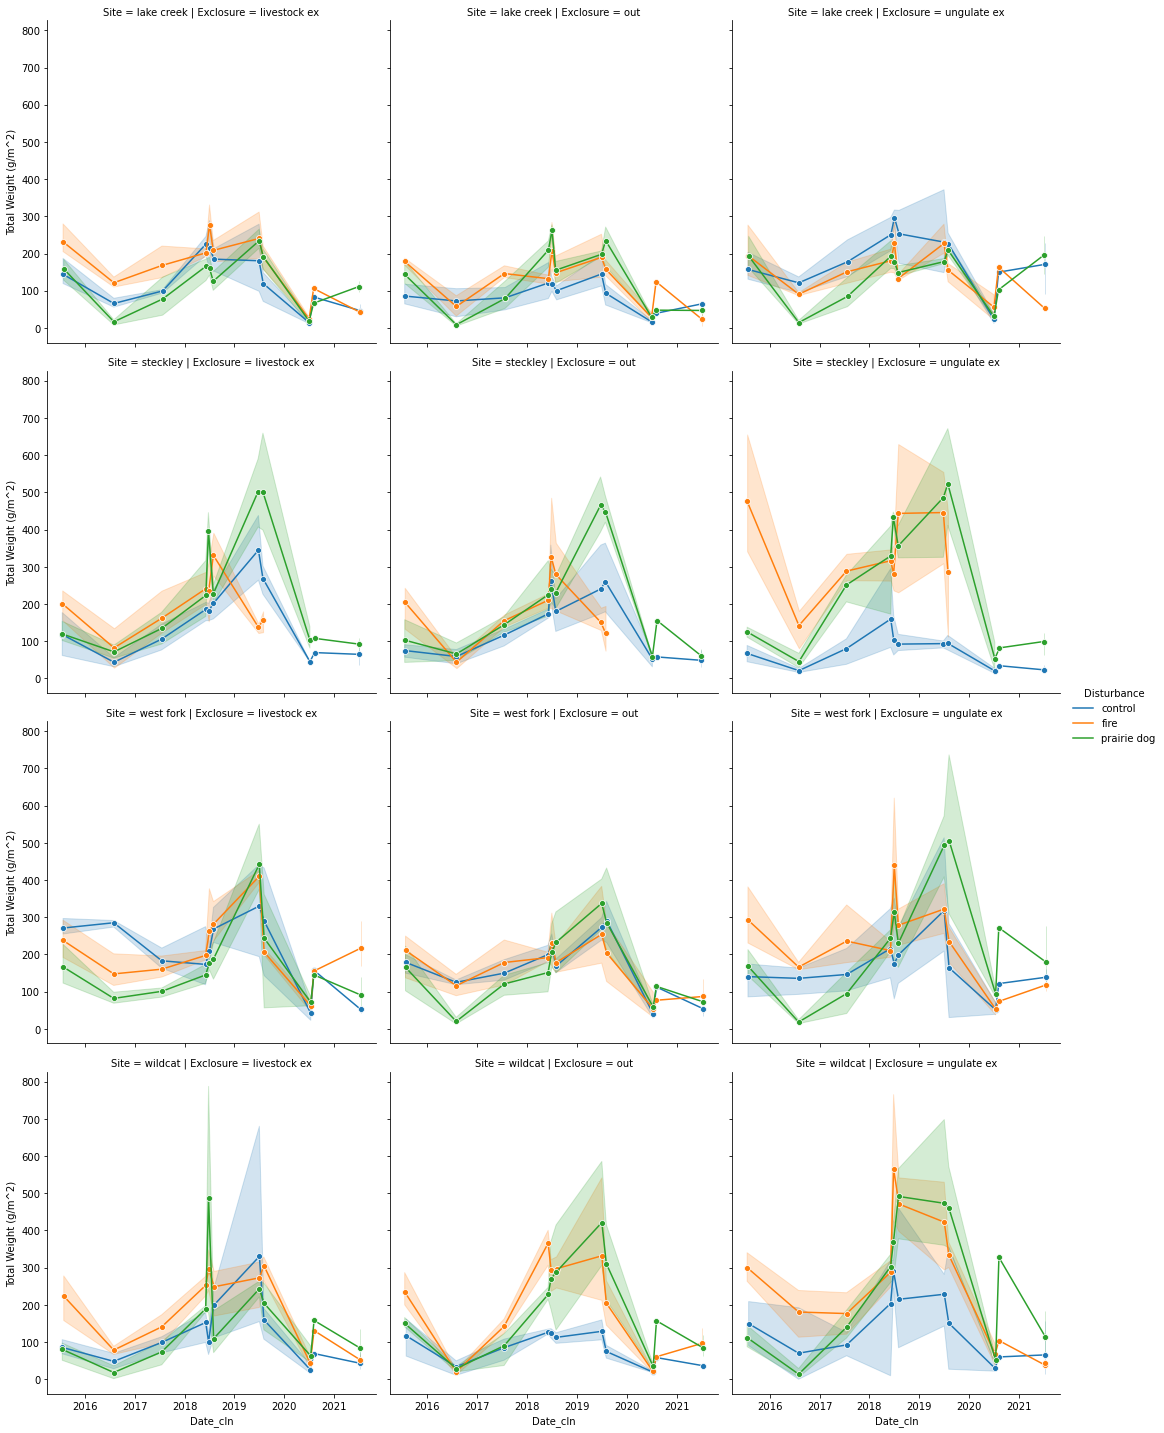

In [13]:
# plot pin-frame calibration data
sns.relplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm, kind='line', marker="o")

### Save biomass data to disk

In [14]:
# aggregate data to experimental unit
remove_indv_na = True
if remove_indv_na:
    df_nex_bm_out = df_nex_bm[~(
        df_nex_bm.loc[:, df_nex_bm.columns.str.contains('weight \(g\)')] < 0).any(axis=1)].groupby(
        ['Site', 
         'Disturbance',
         'Exclosure',
         'Transect ID',
         'Date_cln']).mean().reset_index().sort_values('Date_cln')
else:
    df_nex_bm_out = df_nex_bm.groupby(['Site',
                                       'Disturbance',
                                       'Exclosure',
                                       'Transect ID',
                                       'Date_cln']).mean().reset_index().sort_values('Date_cln')

In [15]:
# check that all ID's are in shapefile
df_nex_bm_out['Transect ID'][~df_nex_bm_out['Transect ID'].isin(gdf_nex['Transect ID'].unique())].unique()

array([], dtype=object)

In [16]:
# check that all ID's are in dataset
gdf_nex['Transect ID'][~gdf_nex['Transect ID'].isin(df_nex_bm_out['Transect ID'].unique())].unique()

array([], dtype=object)

In [19]:
# get GPS locs from transect shapefile (centroids)
df_nex_bm_out = pd.merge(df_nex_bm_out,
                         gdf_nex[['Transect ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                         on= 'Transect ID',
                         suffixes=['_clip', '_shp'],
                         how='left')

In [20]:
# save data to disk
df_nex_bm_out.to_csv(os.path.join(os.getcwd(), outDIR_clip, 'TB_nex_clip.csv'), index=False)

### Prep biomass values for joining to pin frame

In [21]:
# create separate biomass dataframe that has functional group data for pinframe calibration
df_nex_bm_fg = df_nex_bm[df_nex_bm['Pin Frame?'] == 'x'].copy(deep=True)

In [22]:
# fill all functional group clipping NA values with zeros for averaging
df_nex_bm_fg.loc[
    :, df_nex_bm_fg.columns.str.contains('weight \(g\)')] = df_nex_bm_fg.loc[
    :, df_nex_bm_fg.columns.str.contains('weight \(g\)')].fillna(0)
df_nex_bm_fg.loc[:, 'BOGR/BUDA'] = df_nex_bm_fg.loc[:, 'BOGR/BUDA'].fillna(0)

# remove all rows with negative values or convert to NAN
remove_indv_na = False
if remove_indv_na:
    df_nex_bm_fg = df_nex_bm_fg[~(
        df_nex_bm_fg.loc[:, df_nex_bm_fg.columns.str.contains('weight \(g\)')] < 0).any(axis=1)]
    df_nex_bm_fg = df_nex_bm_fg[~(df_nex_bm_fg.loc[:, 'BOGR/BUDA'] < 0)]
else:
    for c in list(df_nex_bm_fg.columns[df_nex_bm_fg.columns.str.contains('weight \(g\)')]) + ['BOGR/BUDA']:
        df_nex_bm_fg[c] = df_nex_bm_fg[c].apply(lambda x: np.nan if x < 0 else x)

In [23]:
df_nex_bm_fg.loc[
    :, df_nex_bm_fg.columns.str.contains('weight \(g\)')].columns

Index(['C4 weight (g)', 'C3 weight (g)', 'Bromes weight (g)',
       'Forbs weight (g)', 'Ann Forb weight (g)', 'Per Forb weight (g)',
       'VUOC weight (g)', 'Subshrub weight (g)', 'Standing Dead weight (g)'],
      dtype='object')

In [24]:
# create additional functional group groupings
df_nex_bm_fg['Ann Grass weight (g)'] = df_nex_bm_fg['Bromes weight (g)'] + df_nex_bm_fg['VUOC weight (g)']

In [25]:
# create consistent Forbs weight across all years
forb_years = df_nex_bm_fg.loc[(df_nex_bm_fg['Forbs weight (g)'].isnull() | df_nex_bm_fg['Forbs weight (g)'] == 0) & 
              (df_nex_bm_fg[['Ann Forb weight (g)', 'Per Forb weight (g)']].notnull().all(axis=1) & 
               df_nex_bm_fg[['Ann Forb weight (g)', 'Per Forb weight (g)']].sum(axis=1) != 0),
                           'Year'].unique()
df_nex_bm_fg['Forbs weight (g)'] = df_nex_bm_fg.apply(
    lambda x: (x['Ann Forb weight (g)'] + x['Per Forb weight (g)']) if x['Year'] in forb_years else x['Forbs weight (g)'],
    axis=1)

# create consistent C4 weight across all years
c4_years = df_nex_bm_fg.loc[(df_nex_bm_fg['BOGR/BUDA'].notnull() | df_nex_bm_fg['BOGR/BUDA'] != 0) &
                            (df_nex_bm_fg['C4 weight (g)'].isnull() | df_nex_bm_fg['C4 weight (g)'] == 0), 'Year'].unique()

df_nex_bm_fg['C4 weight (g)'] = df_nex_bm_fg.apply(
    lambda x: x['C4 weight (g)'] + x['BOGR/BUDA'] if x['Year'] in c4_years else x['C4 weight (g)'],
    axis=1)

In [26]:
c4_years

array([2017, 2018, 2019, 2020], dtype=int64)

In [27]:
# create columns for aerial density of functional group biomass
for c in [c for c in df_nex_bm_fg.columns if ' (g)' in c]:
    df_nex_bm_fg[re.sub(' \(g\)', ' (g/m^2)', c)] = df_nex_bm_fg[c] * 2.0

In [28]:
df_nex_bm_fg.loc[((df_nex_bm_fg['Forbs weight (g)'].isnull()) | (df_nex_bm_fg['Forbs weight (g)'] == 0)) & 
              (df_nex_bm_fg[['Ann Forb weight (g)', 'Per Forb weight (g)']].sum(axis=1) != 0)]

,Year,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,Pin Frame?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)
1274,2020,8/4/2020-8/5/2020,west fork-control-ungulate ex,west fork,control,ungulate ex,1,x,x,x,...,4.70,24.44,11.2200,NaN,NaN,0.6,0.3164,22.1,58.20,11.5364
1281,2020,2020-08-06 00:00:00,wildcat-control-livestock ex,wildcat,control,livestock ex,1,x,x,x,...,11.46,38.86,0.0218,NaN,0.0332,NaN,0.0400,0.0,18.74,0.0618


In [29]:
df_nex_bm_fg.loc[((df_nex_bm_fg['C4 weight (g)'].isnull()) | (df_nex_bm_fg['C4 weight (g)'] == 0)) & 
              (df_nex_bm_fg['BOGR/BUDA'].notnull() & df_nex_bm_fg['BOGR/BUDA'] != 0)]

,Year,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,Pin Frame?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)


In [30]:
df_nex_bm_fg.loc[df_nex_bm_fg['C4 weight (g)'].isnull()]

,Year,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,Pin Frame?,...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)


### Visualize data to check that it makes sense

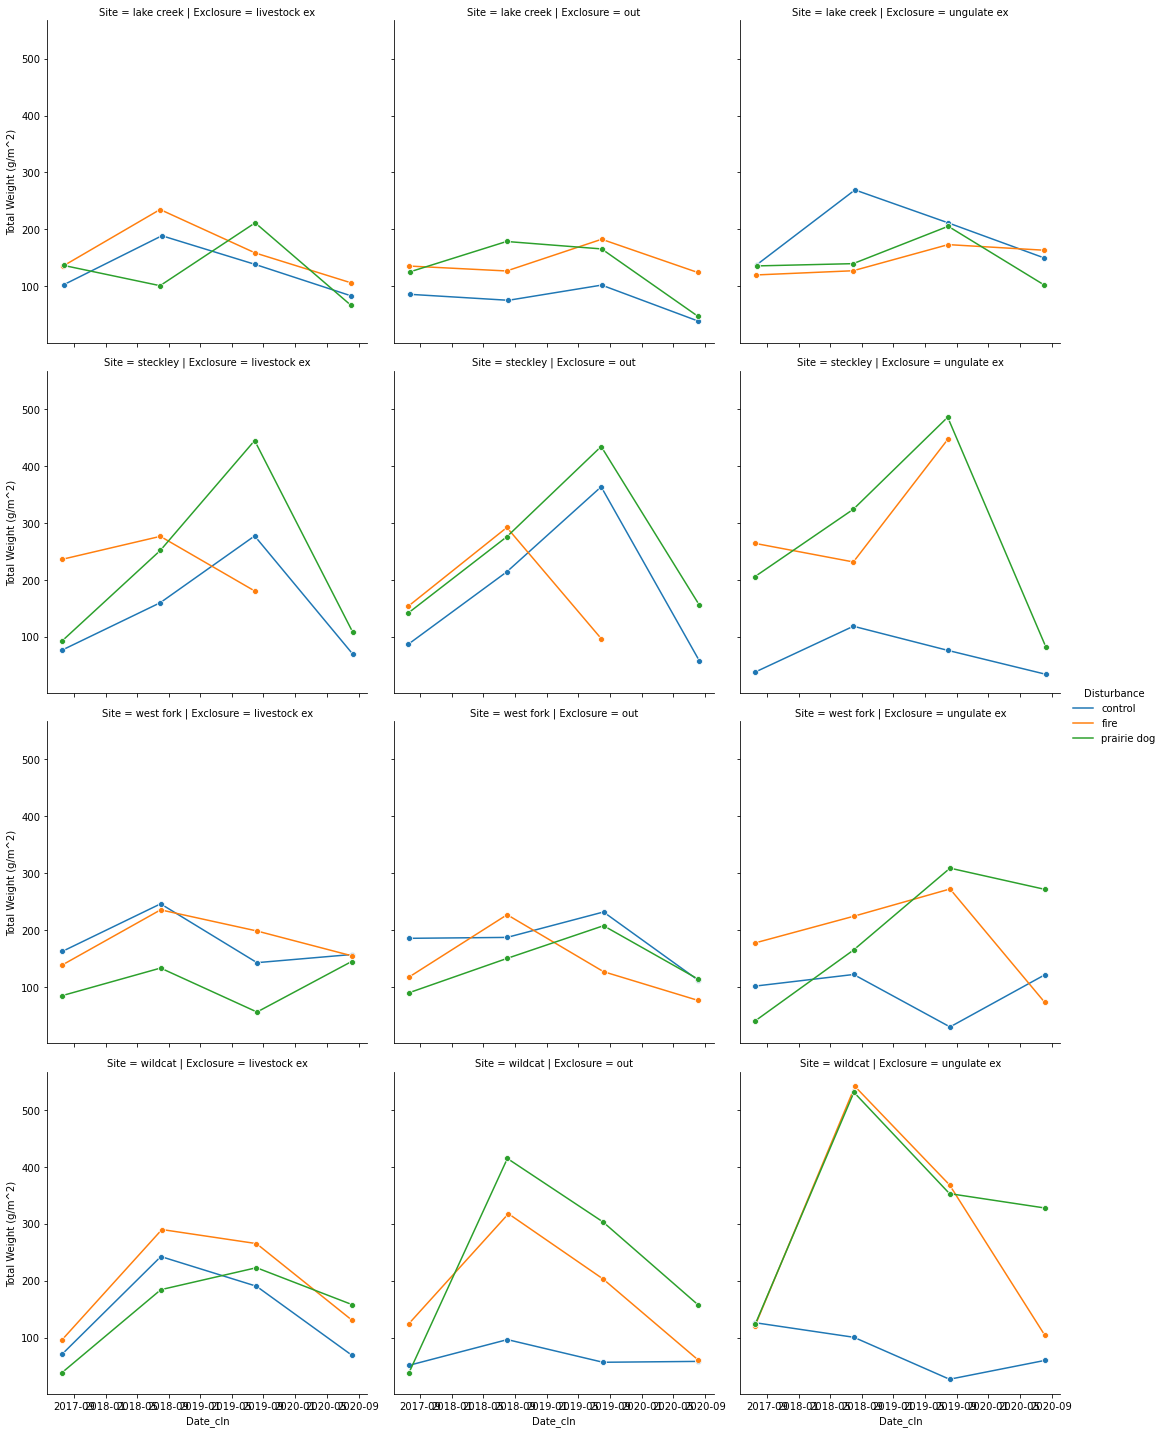

In [31]:
# plot pin-frame calibration data
sns.relplot(x='Date_cln', y='Total Weight (g/m^2)', hue='Disturbance', col='Exclosure', row='Site',
            data=df_nex_bm_fg, kind='line', marker="o")

# Pin Frame Dataset

### Combine Biomass and Pin Frame datasets

In [32]:
# Create a new column in the Pin Frame dataframe pulling the nearest Biomass sampling date
df_nex_pf = pd.merge_asof(df_nex_pf.sort_values('Date'), 
                          df_nex_bm_fg.groupby(['Site',
                                             'Disturbance',
                                             'Exclosure',
                                             'Date_cln']).mean().reset_index().sort_values('Date_cln')[['Site',
                                                                                                        'Disturbance',
                                                                                                        'Exclosure',
                                                                                                        'Total Weight (g/m^2)',
                                                                                                        'C4 weight (g/m^2)',
                                                                                                        'C3 weight (g/m^2)', 
                                                                                                        'Forbs weight (g/m^2)', 
                                                                                                        'Bromes weight (g/m^2)',
                                                                                                        'VUOC weight (g/m^2)',
                                                                                                        'Ann Grass weight (g/m^2)', 
                                                                                                        'Subshrub weight (g/m^2)',
                                                                                                        'Standing Dead weight (g/m^2)',
                                                                                                        'Date_cln']],
                          left_on='Date',
                          right_on='Date_cln',
                          by=['Site', 'Disturbance', 'Exclosure'],
                          direction='nearest',
                          tolerance=datetime.timedelta(days=15),
                          suffixes=['_x', ''])

In [33]:
# drop any records missing Biomass data
df_nex_pf = df_nex_pf[df_nex_pf['Total Weight (g/m^2)'].notnull()]

In [34]:
# Check that all values in the newly created column are present in the Biomass dates (result should be empty)
df_nex_pf['Date_cln'].sort_values().astype('str')[~df_nex_pf['Date_cln'].sort_values().isin(
    df_nex_bm_fg[df_nex_bm_fg['Year'] >= 2017]['Date_cln'])].unique()

array([], dtype=object)

### Clean up Pin Frame dataset

In [35]:
# drop basal hits
df_nex_pf = df_nex_pf[df_nex_pf['Position'] != 'basal']

# drop shrub and cactus hits since no clip data available
df_nex_pf = df_nex_pf.drop(columns='Shrub/OPPO')

In [36]:
# calculate forb hits
df_nex_pf['Forb'] = df_nex_pf['AnnualForb'] + df_nex_pf['PerennialForb']

# calculate annual grass hits
df_nex_pf['Annual Grass'] = df_nex_pf['Brome'] + df_nex_pf['VUOC']

### Calculate appropriate values at the experimental unit level

In [37]:
# aggregate data by experimental unit
df_nex_pf_agg = df_nex_pf.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_cln']).aggregate(
    {'Total Hits': np.sum,
     'C4P Grass': np.sum,
     'C3P Grass': np.sum,
     'Annual Grass': np.sum,
     'Forb': np.sum,
     'Brome': np.sum,
     'VUOC': np.sum,
     'Subshrub': np.sum,
     'StandingDead': np.sum,
     'TotalHerbHits': np.sum,
     'Total Weight (g/m^2)': np.mean,
     'C4 weight (g/m^2)': np.mean,
     'C3 weight (g/m^2)': np.mean,
     'Forbs weight (g/m^2)': np.mean,
     'Bromes weight (g/m^2)': np.mean,
     'VUOC weight (g/m^2)': np.mean,
     'Ann Grass weight (g/m^2)': np.mean,
     'Subshrub weight (g/m^2)': np.mean,
     'Standing Dead weight (g/m^2)': np.mean}).reset_index()

In [38]:
pf_colname_mapper = {
    'C4P Grass': 'hits_C4',
    'C3P Grass': 'hits_C3',
    'Annual Grass': 'hits_AnnGrass',
    'Forb': 'hits_Forb',
    'Brome': 'hits_Brome',
    'VUOC': 'hits_VUOC',
    'Subshrub': 'hits_Subshrub',
    'StandingDead': 'hits_SD',
    'TotalHerbHits': 'hits_Total',
    'C4 weight (g/m^2)': 'weight_C4',
    'C3 weight (g/m^2)': 'weight_C3',
    'Ann Grass weight (g/m^2)': 'weight_AnnGrass',
    'Forbs weight (g/m^2)': 'weight_Forb',
    'Bromes weight (g/m^2)': 'weight_Brome',
    'VUOC weight (g/m^2)': 'weight_VUOC',
    'Subshrub weight (g/m^2)': 'weight_Subshrub',
    'Standing Dead weight (g/m^2)': 'weight_SD',
    'Total Weight (g/m^2)': 'weight_Total'
}

df_nex_pf_agg = df_nex_pf_agg.rename(columns=pf_colname_mapper)

In [39]:
# reset the year column
df_nex_pf_agg['Year'] = df_nex_pf_agg['Date_cln'].dt.year

# rename date column
df_nex_pf_agg = df_nex_pf_agg.rename(columns={'Date_cln': 'Date'})

### Create long-form version of data

In [40]:
# convert to long format to be able to plot with hue as the FG
df_nex_pf_agg_long = pd.wide_to_long(df_nex_pf_agg.reset_index(), 
                                     stubnames=['hits', 'weight'], 
                                     i=['Site', 'Disturbance', 'Exclosure', 'Date'], 
                                     j='FG', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

### Check data and save to disk

In [41]:
df_nex_bm_fg.groupby('Year').count()

,Date,Transect ID,Site,Disturbance,Exclosure,Rep,Biomass?,Forage?,Pin Frame?,Area (m^2),...,C4 weight (g/m^2),C3 weight (g/m^2),Bromes weight (g/m^2),Forbs weight (g/m^2),Ann Forb weight (g/m^2),Per Forb weight (g/m^2),VUOC weight (g/m^2),Subshrub weight (g/m^2),Standing Dead weight (g/m^2),Ann Grass weight (g/m^2)
Year,,,,,,,,,,,,,,,,,,,,,
2017,36,36,36,36,36,36,36,0,36,36,...,36,36,36,36,36,36,36,36,36,36
2018,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
2019,36,36,36,36,36,36,36,36,36,36,...,36,35,35,36,36,36,36,36,36,35
2020,33,33,33,33,33,33,33,33,33,33,...,33,33,33,31,32,32,32,33,33,32


In [42]:
df_nex_pf_agg_long.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,FG,index,Total Hits,hits,weight
Year,,,,,,,,,
2017,324,324,324,324,324,324,324,324,324
2018,324,324,324,324,324,324,324,324,324
2019,324,324,324,324,324,324,324,324,321
2020,297,297,297,297,297,297,297,297,293


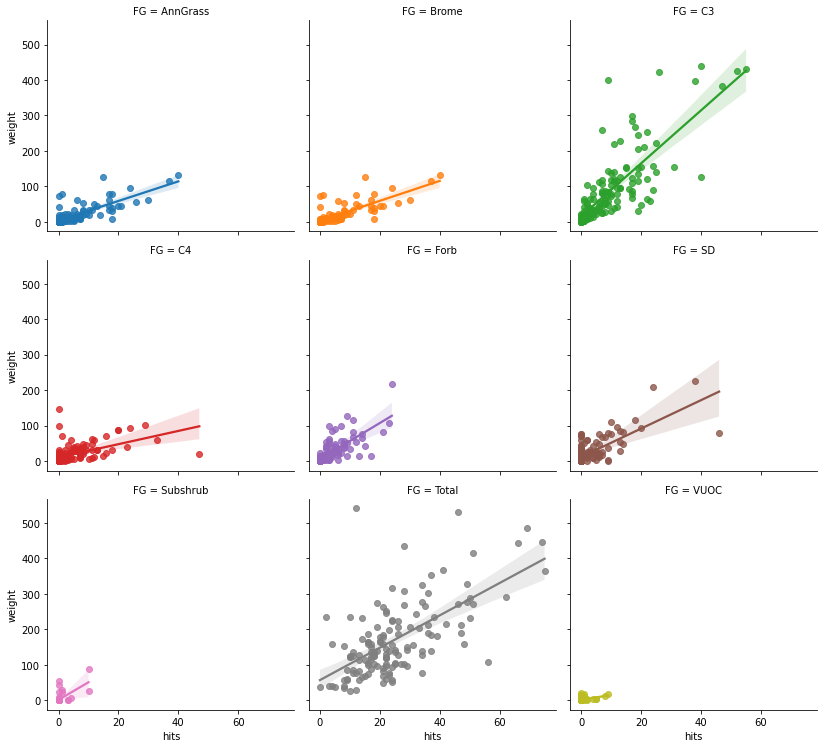

In [43]:
# plot linear fits for each functional group (FG)
sns.lmplot(x='hits',
           y='weight',
           col='FG',
           col_wrap=3,
           hue='FG',
           data=df_nex_pf_agg_long,
           scatter=True, height=3.5, aspect=1.1)

In [44]:
# explore outliers
df_nex_pf_agg[(df_nex_pf_agg.hits_C4 < 5) & (df_nex_pf_agg.weight_C4 > 50)]

,Site,Disturbance,Exclosure,Date,Total Hits,hits_C4,hits_C3,hits_AnnGrass,hits_Forb,hits_Brome,...,weight_Total,weight_C4,weight_C3,weight_Forb,weight_Brome,weight_VUOC,weight_AnnGrass,weight_Subshrub,weight_SD,Year
2,lake creek,control,livestock ex,2019-07-31,23,1,0,20,2,20,...,138.52,71.30,0.00,18.7,44.90,0.02,44.92,0.0,3.6,2019
26,lake creek,prairie dog,livestock ex,2019-07-31,37,4,3,26,3,26,...,211.60,59.70,37.70,56.3,53.60,1.90,55.50,0.0,2.4,2019
48,steckley,fire,livestock ex,2017-07-17,2,0,2,0,0,0,...,235.90,148.06,47.52,0.0,40.32,0.00,40.32,0.0,0.0,2017
51,steckley,fire,out,2017-07-17,8,0,8,0,0,0,...,153.82,99.64,53.60,0.0,0.58,0.00,0.58,0.0,0.0,2017


In [45]:
# drop meaningless columns
df_nex_pf_agg_long = df_nex_pf_agg_long.drop(columns=['index'])
# save datasets to disk
df_nex_pf_agg.to_csv(os.path.join(os.getcwd(), outDIR_pf_train, 'TB_nex_pf_train.csv'), index=False)
df_nex_pf_agg_long.to_csv(os.path.join(os.getcwd(), outDIR_pf_train, 'TB_nex_pf_train_long.csv'), index=False)

# VOR

In [60]:
# load vor data
df_nex_vor = nex_xlsx.parse(sheet_name='VOR 15-21', header=0)

### VOR dataset cleaning, aggregation and save to disk

In [61]:
# get manually adjusted low/high readings
# see T:\2-Projects\Thunder Basin\NestedExclosures\Data\Multi-Year Data\README-VORrulesforfixingdata.docx
df_nex_vor['Low_cm'] = df_nex_vor['low_cm_ADJUSTED']
df_nex_vor['High_cm'] = df_nex_vor['High_cm_ADJUSTED']
df_nex_vor = df_nex_vor.drop(columns=['low_cm_ADJUSTED', 'High_cm_ADJUSTED'])

In [62]:
# manually fix incorrect Transect ID
df_nex_vor.loc[(df_nex_vor['Exclosure'] == 'ungulate ex') & 
               (df_nex_vor['Transect ID'] == 'lake creek-prairie dog-livestock ex'),
              'Transect ID'] = 'lake creek-prairie dog-ungulate ex'

In [63]:
# fix erroneous species names
spp_remap_dict = {'HECI': 'HECO',
                  'JECO': 'HECO'}
df_nex_vor['Spp_code'] = df_nex_vor['Spp_code'].apply(lambda x: spp_remap_dict[x] if x in spp_remap_dict.keys() else x)

In [64]:
# create list of species to drop from VOR data
vor_spp_drop_list = ['ATCA', 'atca', 'OPPO', 'oppo', 'ARTR', 'artr', 'SD ARTR', 'ARCA', 'arca', 'SD ATCA']

# drop VOR readings in species list
df_nex_vor = df_nex_vor[~df_nex_vor['Spp_code'].isin(vor_spp_drop_list)]

# convert 'High_cm back to integer'
df_nex_vor.loc[df_nex_vor['High_cm'] == '90+', 'High_cm'] = 90
df_nex_vor['High_cm'] = df_nex_vor['High_cm'].astype('int')

# drop VOR where low > high as suspected data entry errors
df_nex_vor = df_nex_vor[df_nex_vor['Low_cm'] <= df_nex_vor['High_cm']]

# drop any VOR readings of -1
df_nex_vor = df_nex_vor[(df_nex_vor['Low_cm'] >= 0) & (df_nex_vor['High_cm'] >= 0)]

# get total number of vor obs per site
vor_reading_cts = df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Transect ID',
     'Date_Surveyed']).count()['Distance_along_transect_m']

# get percentage of readings remaining after dropping species
vor_reading_pct = (df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Transect ID',
     'Date_Surveyed']).count()['Distance_along_transect_m'] / vor_reading_cts).reset_index()

In [65]:
# get mean of each experimental unit
df_nex_vor_out = df_nex_vor.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Transect ID', 'Date_Surveyed']).mean().reset_index()

# get percent of valid herbaceous readings
df_nex_vor_out['vor_reading_pct'] = vor_reading_pct['Distance_along_transect_m']

# drop any sites where < 50% of readings are valid
df_nex_vor_out = df_nex_vor_out[df_nex_vor_out['vor_reading_pct'] > 0.5]

# reset the year column
df_nex_vor_out['Year'] = df_nex_vor_out['Date_Surveyed'].dt.year

# drop meaningless columns
df_nex_vor_out = df_nex_vor_out.drop(columns=['Distance_along_transect_m'])

# rename date columns
df_nex_vor_out = df_nex_vor_out.rename(columns={'Date_Surveyed': 'Date'})

In [66]:
# get GPS locs from transect shapefile (centroids)
df_nex_vor_out = pd.merge(df_nex_vor_out,
                          gdf_nex[['Transect ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                          on= 'Transect ID',
                          suffixes=['_vor', '_shp'],
                          how='left')

In [67]:
df_nex_vor_out

,Site,Disturbance,Exclosure,Transect ID,Date,Year,High_cm,Low_cm,vor_reading_pct,Mean.GPS_E.Biomass,Mean.GPS_N.Biomass
0,lake creek,control,livestock ex,lake creek-control-livestock ex,2015-07-01,2015,38.621622,10.594595,1.0,490771.571731,4.797154e+06
1,lake creek,control,livestock ex,lake creek-control-livestock ex,2016-07-05,2016,30.810811,5.702703,1.0,490771.571731,4.797154e+06
2,lake creek,control,livestock ex,lake creek-control-livestock ex,2017-07-04,2017,26.555556,5.944444,1.0,490771.571731,4.797154e+06
3,lake creek,control,livestock ex,lake creek-control-livestock ex,2018-07-03,2018,37.891892,7.135135,1.0,490771.571731,4.797154e+06
4,lake creek,control,livestock ex,lake creek-control-livestock ex,2019-07-01,2019,33.714286,8.942857,1.0,490771.571731,4.797154e+06
...,...,...,...,...,...,...,...,...,...,...,...
241,wildcat,prairie dog,ungulate ex,wildcat-prairie dog-ungulate ex,2017-07-06,2017,14.550000,2.325000,1.0,517132.712854,4.836253e+06
242,wildcat,prairie dog,ungulate ex,wildcat-prairie dog-ungulate ex,2018-06-26,2018,74.100000,28.125000,1.0,517132.712854,4.836253e+06
243,wildcat,prairie dog,ungulate ex,wildcat-prairie dog-ungulate ex,2019-07-03,2019,53.675000,29.225000,1.0,517132.712854,4.836253e+06
244,wildcat,prairie dog,ungulate ex,wildcat-prairie dog-ungulate ex,2020-07-13,2020,35.150000,10.050000,1.0,517132.712854,4.836253e+06


In [68]:
df_nex_vor_out.to_csv(os.path.join(os.getcwd(), outDIR_vor, 'TB_nex_vor.csv'), index=False)

### *Combine with biomass dataset*

##### *Additional biomass cleaning*

In [69]:
remove_indv_na = True
if remove_indv_na:
    df_nex_bm = df_nex_bm[~(
        df_nex_bm.loc[:, df_nex_bm.columns.str.contains('weight \(g\)')] < 0).any(axis=1)]

In [70]:
# join Biomass and VOR datasets using Biomass dates with a definted maximum threshold of date difference
df_nex_vor = pd.merge_asof(df_nex_vor.sort_values('Date_Surveyed'), 
                           df_nex_bm.groupby(['Site',
                                              'Disturbance',
                                              'Exclosure',
                                              'Date_cln']).mean().reset_index().sort_values('Date_cln')[['Site',
                                                              'Disturbance',
                                                              'Exclosure',
                                                              'Area (m^2)',
                                                              'Total Weight (g)',
                                                              'Total Weight (g/m^2)',
                                                              'Date_cln']],
                           left_on='Date_Surveyed',
                           right_on='Date_cln',
                           by=['Site', 'Disturbance', 'Exclosure'],
                           direction='nearest',
                           tolerance=datetime.timedelta(days=10),
                           suffixes=['_x', ''],)

In [71]:
# drop any records missing Biomass data
df_nex_vor = df_nex_vor[df_nex_vor['Total Weight (g/m^2)'].notnull()]

In [72]:
# get updated total number of vor obs per site
vor_reading_cts = df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln']).count()['Distance_along_transect_m']

### *Clean VOR dataset*

### *Create dataset of mean values by experimental unit*

In [73]:
# get percentage of readings remaining after dropping species
vor_reading_pct = (df_nex_vor.groupby(
    ['Site', 
     'Disturbance', 
     'Exclosure', 
     'Date_Surveyed', 
     'Date_cln']).count()['Distance_along_transect_m'] / vor_reading_cts).reset_index()

# get mean of each experimental unit
df_nex_vor_agg = df_nex_vor.groupby(
    ['Site', 'Disturbance', 'Exclosure', 'Date_Surveyed', 'Date_cln']).mean().reset_index()

# get percent of valid herbaceous readings
df_nex_vor_agg['vor_reading_pct'] = vor_reading_pct['Distance_along_transect_m']

# drop any sites where < 50% of readings are valid
df_nex_vor_agg = df_nex_vor_agg[df_nex_vor_agg['vor_reading_pct'] > 0.5]

# reset the year column
df_nex_vor_agg['Year'] = df_nex_vor_agg['Date_Surveyed'].dt.year

# drop meaningless columns
df_nex_vor_agg = df_nex_vor_agg.drop(columns=['Distance_along_transect_m'])

# rename date columns
df_nex_vor_agg = df_nex_vor_agg.rename(columns={'Date_Surveyed': 'Date'})

### *Check data and save to disk*

In [74]:
df_nex_vor_agg.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,Date_cln,High_cm,Low_cm,Area (m^2),Total Weight (g),Total Weight (g/m^2),vor_reading_pct
Year,,,,,,,,,,,
2015,2,2,2,2,2,2,2,2,2,2,2
2018,36,36,36,36,36,36,36,36,36,36,36
2019,36,36,36,36,36,36,36,36,36,36,36
2020,29,29,29,29,29,29,29,29,29,29,29
2021,37,37,37,37,37,37,37,37,37,37,37


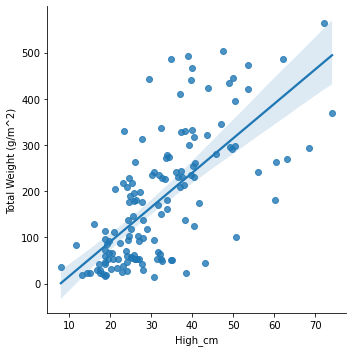

In [75]:
# plot linear fit of low VOR reading and Biomass
sns.lmplot(x='High_cm', 
           y='Total Weight (g/m^2)',
          data=df_nex_vor_agg)

In [76]:
# save final data to disk
df_nex_vor_agg.to_csv(os.path.join(os.getcwd(), outDIR_vor_train, 'TB_nex_vor_train.csv'), index=False)

# Questions
### Biomass 
* What is the Rep? Only one rep for Pin frame and 3 reps for BM..
  * should I average all reps or just take Rep 1?
 
### Pin frame 
* What should be the final functional groups?
  * currently considering:
     * Annuals (BROME + VUOC)
     * Forbs (PerFORB + AnnFORB)
     * C3
     * C4
     * Subshrub
* How to combine functional group in model?
  * currently planning separate models for each FG
* What is TotalHerbHits? Do I need to calculate herb weight?
  * currently I am calculaing an herb weight from biomass clipping as: Total - SD
* Should I be dropping basal hits?
* Ok to drop Shrub/Oppo (no corresponding Biomass clipping)
  * or should we sites with high shrub/oppo?
* PASM vs. COMP? (!this is just for FQ)

### VOR 
* Which species to drop from VOR?
  * for CPER we dropped: ['OPPO', 'ATCA', 'GUSA', 'EREF', 'ARFR', 'ERNA', 'KRLA', 'YUGL']
  * currently I am just dropping OPPO and ATCA
* Should I clean up outliers?
  * for CPER we used cut-off of 50 cm height (for high) and 2.5 sd's
  * currently I am removing high > 75 cm and low > high
* Max date difference between clipping and VOR?
  * currently I am using 15 days
  
### PVSAGE
* Anything different to be aware of?
* Only use pre-treatment data for satellite extraction?
    * Is the first year (2016?) baseline data pre-treatment? 

In [60]:
#remove negative values
# red cells will be NAN (check latest saved data)
# Note that there is biomass data with no corresponding PF data (and not by FG)
#drop all biomass data not used for pin frame calibration before PF join (then you won't be worrying about reps).
#Add BOGR/BUDA back into C4 when present (starting in 2020)
#drop all PASM data from Biomass
#starting in 2019 need to add together annual and perennial forbs, but prior is just forbs

# VOR
#leave all high numbers. Change 90+ to 90
# could check datasheets when low > high (ask Katie)
#change date tolerance to 10 days max (look at VOR, should through out all of 2015-17, but very few in 2018+),
#maybe reduce tolerance if needbe
# YEAR IS WRONG FOR VOR DATA
# CHANGE JUNE 2016 AND JUNE AND JULY 2017 DATES FOR VOR BIOMASS TO BE LATE JUNE AND EARLY JULY??